### Calculations and plotting for Figure 3, Figure S7, and Figure S8

#### import statements

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
import importlib

In [3]:
from project_utils import parameters as param
from project_utils import fig_utils as figu
from project_utils import utils as util

importlib.reload(figu)
importlib.reload(param)
importlib.reload(util)

<module 'project_utils.parameters' from '/oak/stanford/groups/omramom/group_members/fvdav/projects/precip_clustering/project_utils/parameters.py'>

In [4]:
## set plot configurations
figu.set_plt_rc_params()

### Read data

Midwest regional precipitation time series:

In [5]:
with open("../processed_data/region_mean_precip.csv", mode = "r") as f:
    precip_dat = pd.read_csv(f)
    
precip_dat['time'] = pd.to_datetime(precip_dat['time'])

In [6]:
pr_thr = precip_dat["prcp"].quantile(0.95)

load class predictions:

In [7]:
class_prob = pd.read_csv("../processed_data/predicted_class_data.csv")

In [8]:
class_prob['date'] = pd.to_datetime(class_prob.date)

In [9]:
ones_dates = class_prob.loc[class_prob.predicted_class == 1].date
zero_dates = class_prob.loc[class_prob.predicted_class == 0].date
ones_precip = precip_dat[precip_dat.time.isin(ones_dates.values)]
zero_precip = precip_dat[precip_dat.time.isin(zero_dates.values)]

#### Calculate changes in class occurrence and precipitation:

In [10]:
class1_count = pd.DataFrame(ones_dates.groupby(ones_dates.dt.year).count()).rename(columns={'date': 'count'})
class1_precip = ones_precip.groupby(ones_precip.time.dt.year).mean().rename_axis('year')

In [11]:
def calc_trends(dat, cutoffyear = 2000):
    x = dat.index
    early_ind = (x) < cutoffyear
    late_ind = (x >= cutoffyear)
    y = dat.values
    df = pd.DataFrame({"var": [dat.columns[0]]})
    df[['int', 'slope', 'pval']] = util.fit_ols(x, y)
    df[['int_early', 'slope_early', 'pval_early']] = util.fit_ols(x[early_ind], y[early_ind])
    df[['int_late', 'slope_late', 'pval_late']] = util.fit_ols(x[late_ind], y[late_ind])
    df["cutoff_year"] = cutoffyear

    return(df)

In [12]:
trend_dat = calc_trends(class1_count)
trend_dat = trend_dat.append(calc_trends(class1_precip))
trend_dat

,var,int,slope,pval,int_early,slope_early,pval_early,int_late,slope_late,pval_late,cutoff_year
0,count,-284.171390,0.171457,0.181111,250.175439,-0.096491,0.778552,-2010.63609,1.030075,0.004527,2000
0,prcp,-35.824531,0.020778,0.010540,28.648197,-0.011626,0.581064,-79.22523,0.042381,0.070535,2000


In [13]:
trend_test = pd.DataFrame()

for year in range(1997, 2004):
    trend_test = trend_test.append(calc_trends(class1_count, cutoffyear = year))
    trend_test = trend_test.append(calc_trends(class1_precip, cutoffyear = year))

trend_test = trend_test.drop(columns = ["int", "slope", "pval", "int_early", "int_late"]).melt(
    id_vars = ["cutoff_year", "var"], 
    value_vars = ["slope_early", "pval_early", "slope_late", "pval_late"]).pivot_table(
    columns = ["variable", "var"], index = "cutoff_year").sort_index(axis='columns', level='var')

trend_test = np.round(trend_test, 3)
trend_test.to_csv("../processed_data/trend_cutoff_year_sensitivity.csv")
trend_test

value                                                        \
variable    pval_early pval_late slope_early slope_late pval_early pval_late   
var              count     count       count      count       prcp      prcp   
cutoff_year                                                                    
1997             0.485     0.002       0.285      0.897      0.649     0.023   
1998             0.780     0.009      -0.120      0.800      0.747     0.025   
1999             0.893     0.004      -0.052      0.945      0.812     0.029   
2000             0.779     0.005      -0.096      1.030      0.581     0.071   
2001             0.370     0.017      -0.299      0.916      0.438     0.155   
2002             0.317     0.025      -0.303      0.957      0.809     0.103   
2003             0.224     0.049      -0.337      0.926      0.554     0.267   

                                    
variable    slope_early slope_late  
var                prcp       prcp  
cutoff_year                         
1997             -0.013      0.042  
1998             -0.008      0.045  
1999             -0.006      0.048  
2000             -0.012      0.042  
2001             -0.015      0.036  
2002             -0.004      0.046  
2003             -0.010      0.033

#### Calculate distribution of daily precipitation for each class over early/late periods:

In [14]:
pr1e = ones_precip.loc[ones_precip.time.dt.year <= param.early_stop]
pr1l = ones_precip.loc[ones_precip.time.dt.year > param.early_stop]

pr0e = zero_precip.loc[zero_precip.time.dt.year <= param.early_stop]
pr0l = zero_precip.loc[zero_precip.time.dt.year > param.early_stop]

#### Read ghcn station data and calculate precipitation trends for each class at each station:

In [15]:
ghcn_stations = pd.read_table("../input_data/GHCN-Daily/ghcnd-inventory.txt", sep='\s+',
                              names=['ID', 'LATITUDE', 'LONGITUDE', 'ELEMENT', 
                                'FIRST_YEAR', 'LAST_YEAR']) 

In [16]:
ghcn_dat = pd.read_csv("../processed_data/ghcn_midwest_data.csv",
                       dtype = {'ID': 'string', 'DATE': 'int64', 'ELEMENT': 'string', 
                        'DATA_VALUE': 'float64', 'M_FLAG': 'string', 'Q_FLAG': 'string', 
                        'S_FLAG': 'string'})

ghcn_dat['date'] = pd.to_datetime(ghcn_dat['DATE'], format = "%Y%m%d")
ghcn_dat['year'] = pd.to_datetime(ghcn_dat['DATE'], format = "%Y%m%d").dt.year

In [17]:
station_IDs = np.unique(ghcn_dat.ID)

In [18]:
ghcn_epcp = ghcn_dat[ghcn_dat.date.isin(ones_dates.values)]
ghcn_epcp_mean = ghcn_epcp.groupby([ghcn_epcp.ID, ghcn_epcp.year]).mean().reset_index()

ghcn_non_epcp = ghcn_dat[ghcn_dat.date.isin(zero_dates.values)]
ghcn_non_epcp_mean = ghcn_non_epcp.groupby([ghcn_non_epcp.ID, ghcn_non_epcp.year]).mean().reset_index()

In [19]:
ghcn_trends = []
ghcn_trends_late = []
ghcn_trends_nonepcp = []

for sta in station_IDs:
    df = ghcn_epcp_mean.loc[ghcn_epcp_mean.ID == sta]
    ghcn_trends.append(np.polyfit(df.year, df.DATA_VALUE, deg = 1)[0])
    
    df = ghcn_epcp_mean.loc[(ghcn_epcp_mean.ID == sta) & (ghcn_epcp_mean.year >= 2000)]
    ghcn_trends_late.append(np.polyfit(df.year, df.DATA_VALUE, deg = 1)[0])
    
    df = ghcn_non_epcp_mean.loc[ghcn_non_epcp_mean.ID == sta]
    ghcn_trends_nonepcp.append(np.polyfit(df.year, df.DATA_VALUE, deg = 1)[0])

In [20]:
ghcn_plot_df = pd.DataFrame({"ID": station_IDs, "trend": ghcn_trends, 
                             "trend_nonepcp": ghcn_trends_nonepcp, 
                         "trend_late": ghcn_trends_late})

ghcn_plot_df = ghcn_plot_df.join(ghcn_stations.set_index("ID"), on = "ID", how = "left")

### Figure 3:

In [21]:
early_ind = class1_count.index <= param.early_stop
late_ind = class1_count.index > param.early_stop
early_plot_ind = class1_count.index <= param.early_stop + 1

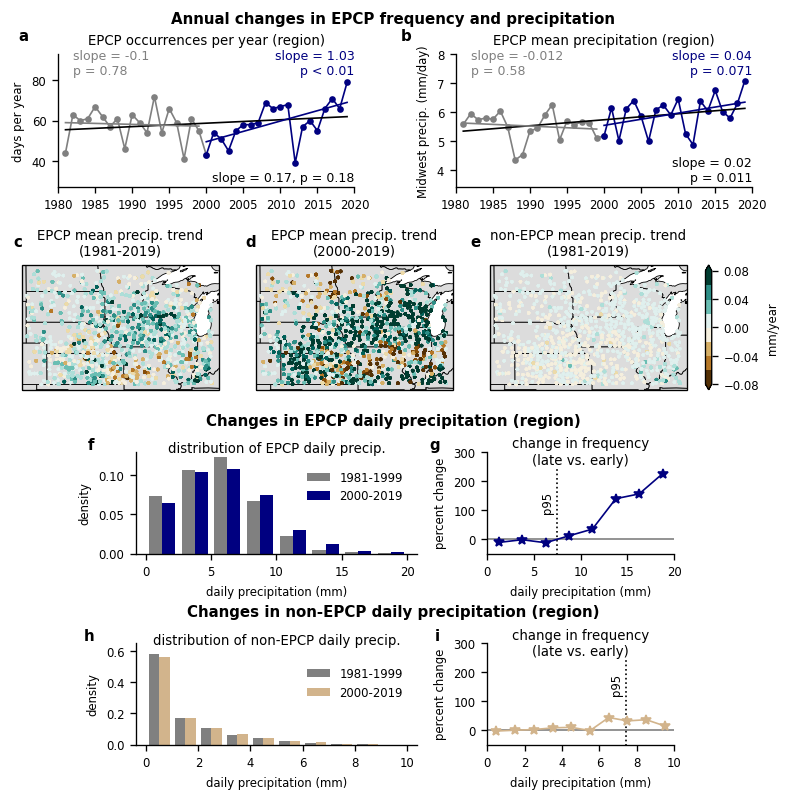

In [22]:
fig = plt.figure(figsize = (6.5, 6.5))

ax = fig.add_axes(np.array([0.07,0.77,0.38,0.17]))

ax.text(0.5, 0.98, 'Annual changes in EPCP frequency and precipitation', weight = 'bold', size = 9, ha = 'center', 
       transform = fig.transFigure)

x = class1_count.index
y = class1_count.values.squeeze()
ax.plot(x[early_plot_ind], y[early_plot_ind], 
        color = figu.base_col, marker = '.')
ax.plot(x[late_ind], y[late_ind], marker = '.', color = figu.class1_col)
## plot trend lines
ax.plot(x, x*trend_dat.iloc[0]['slope']+trend_dat.iloc[0]['int'], color = 'k')
ax.plot(x[early_ind], x[early_ind]*trend_dat.iloc[0]['slope_early']+trend_dat.iloc[0]['int_early'], 
        color = figu.base_col)
ax.plot(x[late_ind], x[late_ind]*trend_dat.iloc[0]['slope_late']+trend_dat.iloc[0]['int_late'], 
        color = figu.class1_col)
## plot text
if (trend_dat.iloc[0]['pval_late'] < 0.01):
    late_string = 'slope = ' + str(np.round(trend_dat.iloc[0]['slope_late'], 2)) + "\np < 0.01"
else:
    late_string = 'slope = ' + str(np.round(trend_dat.iloc[0]['slope_late'], 2)) + '\np = ' + str(np.round(trend_dat.iloc[0]['pval_late'], 2))
ax.text(x = 1, y = 0.04, s = 'slope = ' + str(np.round(trend_dat.iloc[0]['slope'], 2)) + 
        ', p = ' + str(np.round(trend_dat.iloc[0]['pval'], 2)), 
       transform=ax.transAxes, size = 7.5, horizontalalignment='right')
ax.text(x = 0.05, y = 0.85, s = 'slope = ' + str(np.round(trend_dat.iloc[0]['slope_early'], 2)) + 
        '\np = ' + str(np.round(trend_dat.iloc[0]['pval_early'], 2)), 
       transform=ax.transAxes, size = 7.5, color = figu.base_col, horizontalalignment='left')
ax.text(x = 1, y = 0.85, s = late_string, 
       transform=ax.transAxes, size = 7.5, color = figu.class1_col, horizontalalignment='right')
ax.set(title = 'EPCP occurrences per year (region)', 
       ylim = (27,93), xlim = (1980, 2020), ylabel = "days per year")
figu.format_plot(ax)
figu.add_panel_label(ax, 'a', y = 1.2)

ax = fig.add_axes(np.array([0.58,0.77,0.38,0.17]))
x = class1_precip.index
y = class1_precip.values.squeeze()
ax.plot(x[early_plot_ind], y[early_plot_ind], 
        color = figu.base_col, marker = '.')
ax.plot(x[late_ind], y[late_ind], marker = '.', color = figu.class1_col)
## plot trend lines
ax.plot(x, x*trend_dat.iloc[1]['slope']+trend_dat.iloc[1]['int'], color = 'k')
ax.plot(x[early_ind], x[early_ind]*trend_dat.iloc[1]['slope_early']+trend_dat.iloc[1]['int_early'], 
        color = figu.base_col)
ax.plot(x[late_ind], x[late_ind]*trend_dat.iloc[1]['slope_late']+trend_dat.iloc[1]['int_late'], 
        color = figu.class1_col)
## plot text
ax.text(x = 1, y = 0.04, s = 'slope = ' + str(np.round(trend_dat.iloc[1]['slope'], 2)) + 
        '\np = ' + str(np.round(trend_dat.iloc[1]['pval'], 3)), 
       transform=ax.transAxes, size = 7.5, horizontalalignment='right')
ax.text(x = 0.05, y = 0.85, s = 'slope = ' + str(np.round(trend_dat.iloc[1]['slope_early'], 3)) + 
        '\np = ' + str(np.round(trend_dat.iloc[1]['pval_early'], 2)), 
       transform=ax.transAxes, size = 7.5, color = figu.base_col, horizontalalignment='left')
ax.text(x = 1, y = 0.85, s = 'slope = ' + str(np.round(trend_dat.iloc[1]['slope_late'], 2)) + 
        '\np = ' + str(np.round(trend_dat.iloc[1]['pval_late'], 3)), 
       transform=ax.transAxes, size = 7.5, color = figu.class1_col, horizontalalignment='right')
ax.set(title = 'EPCP mean precipitation (region)', 
       ylim = (3.4, 8), xlim = (1980, 2020), ylabel = "Midwest precip. (mm/day)");
figu.format_plot(ax)
figu.add_panel_label(ax, 'b', x = -0.15, y = 1.2)

#### MAPS 
ax = fig.add_axes([0, 0.51, 0.3, 0.16], projection = ccrs.PlateCarree())
p = ax.scatter(ghcn_plot_df.LONGITUDE, ghcn_plot_df.LATITUDE, c=ghcn_plot_df.trend/10, 
               cmap = figu.browngreen, vmin = -.08, vmax = .08, s = 1,
               zorder = 10)
ax.set(title='EPCP mean precip. trend\n(1981-2019)')
figu.format_ghcn_map(ax)
figu.add_panel_label(ax, "c", x = 0, y = 1.25)

ax = fig.add_axes([0.3, 0.51, 0.3, 0.16], projection = ccrs.PlateCarree())
p = ax.scatter(ghcn_plot_df.LONGITUDE, ghcn_plot_df.LATITUDE, c=ghcn_plot_df.trend_late/10, 
               cmap = figu.browngreen, vmin = -.08, vmax = .08, s = 1,
               zorder = 10)
figu.format_ghcn_map(ax)
ax.set(title='EPCP mean precip. trend\n(2000-2019)')
figu.add_panel_label(ax, "d", x = 0, y = 1.25)

ax = fig.add_axes([0.6, 0.51, 0.3, 0.16], projection = ccrs.PlateCarree())
p = ax.scatter(ghcn_plot_df.LONGITUDE, ghcn_plot_df.LATITUDE, c=ghcn_plot_df.trend_nonepcp/10, 
               cmap = figu.browngreen, vmin = -.08, vmax = .08, s = 1,
               zorder = 10)
figu.format_ghcn_map(ax)
ax.set(title='non-EPCP mean precip. trend\n(1981-2019)')
figu.add_panel_label(ax, "e", x = -0.05, y = 1.25)
cbaxes = fig.add_axes([0.9, 0.51, 0.008, 0.16])
cbar = fig.colorbar(p, cax = cbaxes, extend = "both", label = "mm/year", 
                    boundaries = np.arange(-0.1, 0.12, 0.02), 
                   ticks = np.arange(-0.08, 0.12, 0.04))
cbar.ax.tick_params(labelsize=7)

### -----------------------
## Third Row
ax.text(0.5, 0.465, 'Changes in EPCP daily precipitation (region)', weight = 'bold', size = 9, ha = 'center', 
       transform = fig.transFigure)
ax = fig.add_axes([0.17, 0.3, 0.36, 0.13])
p = ax.hist([pr1e.prcp, pr1l.prcp], bins = np.arange(0, 21, 2.5), density = True, color = [figu.base_col, figu.class1_col], 
       label = ['1981-1999', '2000-2019']);
ax.set(ylabel = 'density', xlabel = 'daily precipitation (mm)')
ax.set_title("distribution of EPCP daily precip.", y = 1.0, pad = 0)
ax.legend(bbox_to_anchor = (0.57, 0.4), frameon=False)
figu.format_plot(ax)
figu.add_panel_label(ax, 'f', x = -.15)

ax = fig.add_axes([0.62, 0.3, 0.24, 0.13])
ax.hlines(0, xmin = 0, xmax = 20, color = figu.base_col)
ax.plot(p[1][:-1]+1.25, (p[0][1] - p[0][0])/p[0][0]*100, marker = "*", color = figu.class1_col)
ax.set(xlabel = 'daily precipitation (mm)', xticks = [0, 5, 10, 15, 20], 
       xlim = (0,20), 
       ylim = (-50, 300), ylabel = "percent change")
ax.text(pr_thr - 1.7, 90, s = 'p95', size = 7, rotation = 90, va = 'bottom')
ax.vlines(pr_thr, -100, 250, linestyle = "dotted", color = "k")
ax.set_title('change in frequency\n(late vs. early)', y=1.0, pad = -7)
figu.format_plot(ax)
figu.add_panel_label(ax, 'g', x = -.25)

## Fourth row
ax.text(0.5, 0.22, 'Changes in non-EPCP daily precipitation (region)', weight = 'bold', size = 9, ha = 'center', 
       transform = fig.transFigure)

ax = fig.add_axes([0.17, 0.055, 0.36, 0.13])
p = ax.hist([pr0e.prcp, pr0l.prcp], bins = np.arange(0, 11, 1), density = True, color = [figu.base_col, figu.class0_col], 
       label = ['1981-1999', '2000-2019']);
ax.set(ylabel = 'density', xlabel = 'daily precipitation (mm)', ylim = (0, .65))
ax.set_title("distribution of non-EPCP daily precip.", y = 1.0, pad = -0.3)
ax.legend(bbox_to_anchor = (0.57, 0.35), frameon=False)
figu.format_plot(ax)
figu.add_panel_label(ax, 'h', x = -.15)

ax = fig.add_axes([0.62, 0.055, 0.24, 0.13])
ax.hlines(0, xmin = 0, xmax = 20, color = figu.base_col)
ax.plot(p[1][:-1]+0.5, (p[0][1] - p[0][0])/p[0][0]*100, marker = "*", color = figu.class0_col)
ax.text(pr_thr - .9, 120, s = 'p95', size = 7, rotation = 90, va = 'bottom')
ax.vlines(pr_thr, -100, 250, linestyle = "dotted", color = "k")
ax.set(xlabel = 'daily precipitation (mm)', xlim = (0,10), 
       ylim = (-50, 300), ylabel = "percent change")
ax.set_title('change in frequency\n(late vs. early)', y=1.0, pad = -7)
figu.format_plot(ax)
figu.add_panel_label(ax, 'i', x = -.25)

fig.savefig("../figures/figure_3.pdf")

### Figure S7 
Repeat Fig. 3a-f for days where *P*(EPCP) >= 0.75

In [23]:
c75 = class_prob.loc[class_prob.prob_1 >= 0.75] # c75 = class 1 probability > 0.75

c75_count = pd.DataFrame(c75["date"].groupby(c75.date.dt.year).count()).rename(columns={'date': 'count'})
c75_precip = precip_dat.loc[class_prob.prob_1 >= 0.75].groupby(c75.date.dt.year).mean().rename_axis('year')

trend_c75 = calc_trends(c75_count)
trend_c75 = trend_c75.append(calc_trends(c75_precip))
trend_c75

,var,int,slope,pval,int_early,slope_early,pval_early,int_late,slope_late,pval_late,cutoff_year
0,count,-336.688259,0.183806,0.062500,50.368421,-0.010526,0.970810,-1047.945113,0.537594,0.050342,2000
0,prcp,-43.285905,0.025082,0.012906,16.075913,-0.004755,0.886267,-78.828708,0.042776,0.066224,2000


In [24]:
pr_c75_e = precip_dat.loc[(class_prob.prob_1 >= 0.75) & (precip_dat.time.dt.year <= param.early_stop)]
pr_c75_l = precip_dat.loc[(class_prob.prob_1 >= 0.75) & (precip_dat.time.dt.year > param.early_stop)]

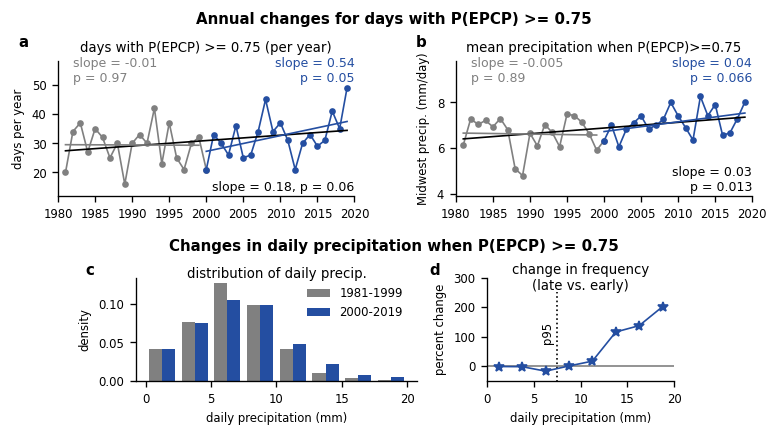

In [25]:
fig = plt.figure(figsize = (6.5, 3.5))

## First Row
ax = fig.add_axes(np.array([0.07,0.55,0.38,0.32]))
ax.text(0.5, 0.96, 'Annual changes for days with P(EPCP) >= 0.75', weight = 'bold', size = 9, ha = 'center', 
       transform = fig.transFigure)

x = c75_count.index
y = c75_count.values.squeeze()
ax.plot(x[early_plot_ind], y[early_plot_ind], 
        color = figu.base_col, marker = '.')
ax.plot(x[late_ind], y[late_ind], marker = '.', color = figu.epcp75_col)
## plot trend lines
ax.plot(x, x*trend_c75.iloc[0]['slope']+trend_c75.iloc[0]['int'], color = 'k')
ax.plot(x[early_ind], x[early_ind]*trend_c75.iloc[0]['slope_early']+trend_c75.iloc[0]['int_early'], 
        color = figu.base_col)
ax.plot(x[late_ind], x[late_ind]*trend_c75.iloc[0]['slope_late']+trend_c75.iloc[0]['int_late'], 
        color = figu.epcp75_col)
ax.text(x = 1, y = 0.04, s = 'slope = ' + str(np.round(trend_c75.iloc[0]['slope'], 2)) + 
        ', p = ' + str(np.round(trend_c75.iloc[0]['pval'], 2)), 
       transform=ax.transAxes, size = 7.5, horizontalalignment='right')
ax.text(x = 0.05, y = 0.85, s = 'slope = ' + str(np.round(trend_c75.iloc[0]['slope_early'], 2)) + 
        '\np = ' + str(np.round(trend_c75.iloc[0]['pval_early'], 2)), 
       transform=ax.transAxes, size = 7.5, color = figu.base_col, horizontalalignment='left')
ax.text(x = 1, y = 0.85, s = 'slope = ' + str(np.round(trend_c75.iloc[0]['slope_late'], 2)) + 
        '\np = ' + str(np.round(trend_c75.iloc[0]['pval_late'], 2)), 
       transform=ax.transAxes, size = 7.5, color = figu.epcp75_col, horizontalalignment='right')
ax.set(title = 'days with P(EPCP) >= 0.75 (per year)', 
       ylim = (12,58), xlim = (1980, 2020), ylabel = "days per year")
figu.format_plot(ax)
figu.add_panel_label(ax, 'a', y = 1.2)

## Second row 
ax = fig.add_axes(np.array([0.58,0.55,0.38,0.32]))
x = c75_precip.index
y = c75_precip.values.squeeze()
ax.plot(x[early_plot_ind], y[early_plot_ind], 
        color = figu.base_col, marker = '.')
ax.plot(x[late_ind], y[late_ind], marker = '.', color = figu.epcp75_col)
## plot trend lines
ax.plot(x, x*trend_c75.iloc[1]['slope']+trend_c75.iloc[1]['int'], color = 'k')
ax.plot(x[early_ind], x[early_ind]*trend_c75.iloc[1]['slope_early']+trend_c75.iloc[1]['int_early'], 
        color = figu.base_col)
ax.plot(x[late_ind], x[late_ind]*trend_c75.iloc[1]['slope_late']+trend_c75.iloc[1]['int_late'], 
        color = figu.epcp75_col)
## plot text
ax.text(x = 1, y = 0.04, s = 'slope = ' + str(np.round(trend_c75.iloc[1]['slope'], 2)) + 
        '\np = ' + str(np.round(trend_c75.iloc[1]['pval'], 3)), 
       transform=ax.transAxes, size = 7.5, horizontalalignment='right')
ax.text(x = 0.05, y = 0.85, s = 'slope = ' + str(np.round(trend_c75.iloc[1]['slope_early'], 3)) + 
        '\np = ' + str(np.round(trend_c75.iloc[1]['pval_early'], 2)), 
       transform=ax.transAxes, size = 7.5, color = figu.base_col, horizontalalignment='left')
ax.text(x = 1, y = 0.85, s = 'slope = ' + str(np.round(trend_c75.iloc[1]['slope_late'], 2)) + 
        '\np = ' + str(np.round(trend_c75.iloc[1]['pval_late'], 3)), 
       transform=ax.transAxes, size = 7.5, color = figu.epcp75_col, horizontalalignment='right')
ax.set(title = 'mean precipitation when P(EPCP)>=0.75', 
       ylim = (3.9, 9.8), xlim = (1980, 2020), ylabel = "Midwest precip. (mm/day)");
figu.format_plot(ax)
figu.add_panel_label(ax, 'b', y = 1.2)

## Third Row
ax.text(0.5, 0.42, 'Changes in daily precipitation when P(EPCP) >= 0.75', weight = 'bold', size = 9, ha = 'center', 
       transform = fig.transFigure)
ax = fig.add_axes([0.17, 0.11, 0.36, 0.245])
p = ax.hist([pr_c75_e.prcp, pr_c75_l.prcp], bins = np.arange(0, 21, 2.5), density = True, 
            color = [figu.base_col, figu.epcp75_col], 
       label = ['1981-1999', '2000-2019']);
ax.set(ylabel = 'density', xlabel = 'daily precipitation (mm)')
ax.set_title("distribution of daily precip.", y = 1.0, pad = 0)
ax.legend(bbox_to_anchor = (0.57, 0.5), frameon=False)
figu.format_plot(ax)
figu.add_panel_label(ax, 'c', x = -.15)

ax = fig.add_axes([0.62, 0.11, 0.24, 0.245])
ax.hlines(0, xmin = 0, xmax = 20, color = figu.base_col)
ax.plot(p[1][:-1]+1.25, (p[0][1] - p[0][0])/p[0][0]*100, marker = "*", color = figu.epcp75_col)
ax.set(xlabel = 'daily precipitation (mm)', xticks = [0, 5, 10, 15, 20], 
       xlim = (0,20), 
       ylim = (-50, 300), ylabel = "percent change")
ax.text(pr_thr - 1.7, 75, s = 'p95', size = 7, rotation = 90, va = 'bottom')
ax.vlines(pr_thr, -100, 250, linestyle = "dotted", color = "k")
ax.set_title('change in frequency\n(late vs. early)', y=1.0, pad = -7)
figu.format_plot(ax)
figu.add_panel_label(ax, 'd', x = -.25)

fig.savefig("../figures/figure_S7.pdf")

### Figure S8
repeat Figure 3a-f using *P*(EPCP) >= 0.9  

In [26]:
c90 = class_prob.loc[class_prob.prob_1 >= 0.9] #c90 = class 1 probability > 0.9

c90_count = pd.DataFrame(c90["date"].groupby(c90.date.dt.year).count()).rename(columns={'date': 'count'})
c90_precip = precip_dat.loc[class_prob.prob_1 >= 0.9].groupby(c90.date.dt.year).mean().rename_axis('year')

trend_c90 = calc_trends(c90_count)
trend_c90 = trend_c90.append(calc_trends(c90_precip))
trend_c90

,var,int,slope,pval,int_early,slope_early,pval_early,int_late,slope_late,pval_late,cutoff_year
0,count,-70.933873,0.041903,0.387502,-151.298246,0.082456,0.562971,-378.373684,0.194737,0.158511,2000
0,prcp,-75.526536,0.041967,0.004587,-94.461770,0.051485,0.254853,-64.878304,0.036666,0.340385,2000


In [27]:
pr_c90_e = precip_dat.loc[(class_prob.prob_1 >= 0.9) & (precip_dat.time.dt.year <= param.early_stop)]
pr_c90_l = precip_dat.loc[(class_prob.prob_1 >= 0.9) & (precip_dat.time.dt.year > param.early_stop)]

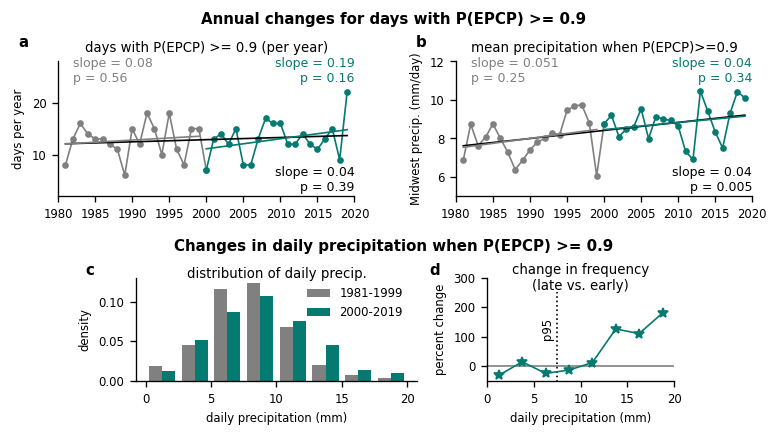

In [28]:
fig = plt.figure(figsize = (6.5, 3.5))

## First Row
ax = fig.add_axes(np.array([0.07,0.55,0.38,0.32]))
ax.text(0.5, 0.96, 'Annual changes for days with P(EPCP) >= 0.9', weight = 'bold', size = 9, ha = 'center', 
       transform = fig.transFigure)

x = c90_count.index
y = c90_count.values.squeeze()
ax.plot(x[early_plot_ind], y[early_plot_ind], 
        color = figu.base_col, marker = '.')
ax.plot(x[late_ind], y[late_ind], marker = '.', color = figu.epcp90_col)
## plot trend lines
ax.plot(x, x*trend_c90.iloc[0]['slope']+trend_c90.iloc[0]['int'], color = 'k')
ax.plot(x[early_ind], x[early_ind]*trend_c90.iloc[0]['slope_early']+trend_c90.iloc[0]['int_early'], 
        color = figu.base_col)
ax.plot(x[late_ind], x[late_ind]*trend_c90.iloc[0]['slope_late']+trend_c90.iloc[0]['int_late'], 
        color = figu.epcp90_col)
## plot text
ax.text(x = 1, y = 0.04, s = 'slope = ' + str(np.round(trend_c90.iloc[0]['slope'], 2)) + 
        '\np = ' + str(np.round(trend_c90.iloc[0]['pval'], 2)), 
       transform=ax.transAxes, size = 7.5, horizontalalignment='right')
ax.text(x = 0.05, y = 0.85, s = 'slope = ' + str(np.round(trend_c90.iloc[0]['slope_early'], 2)) + 
        '\np = ' + str(np.round(trend_c90.iloc[0]['pval_early'], 2)), 
       transform=ax.transAxes, size = 7.5, color = figu.base_col, horizontalalignment='left')
ax.text(x = 1, y = 0.85, s = 'slope = ' + str(np.round(trend_c90.iloc[0]['slope_late'], 2)) + 
        '\np = ' + str(np.round(trend_c90.iloc[0]['pval_late'], 2)), 
       transform=ax.transAxes, size = 7.5, color = figu.epcp90_col, horizontalalignment='right')
ax.set(title = 'days with P(EPCP) >= 0.9 (per year)', 
       ylim = (2,28), xlim = (1980, 2020), ylabel = "days per year")
figu.format_plot(ax)
figu.add_panel_label(ax, 'a', y = 1.2)

## Second row 
ax = fig.add_axes(np.array([0.58,0.55,0.38,0.32]))
x = c90_precip.index
y = c90_precip.values.squeeze()
ax.plot(x[early_plot_ind], y[early_plot_ind], 
        color = figu.base_col, marker = '.')
ax.plot(x[late_ind], y[late_ind], marker = '.', color = figu.epcp90_col)
## plot trend lines
ax.plot(x, x*trend_c90.iloc[1]['slope']+trend_c90.iloc[1]['int'], color = 'k')
ax.plot(x[early_ind], x[early_ind]*trend_c90.iloc[1]['slope_early']+trend_c90.iloc[1]['int_early'], 
        color = figu.base_col)
ax.plot(x[late_ind], x[late_ind]*trend_c90.iloc[1]['slope_late']+trend_c90.iloc[1]['int_late'], 
        color = figu.epcp90_col)
## plot text
ax.text(x = 1, y = 0.04, s = 'slope = ' + str(np.round(trend_c90.iloc[1]['slope'], 2)) + 
        '\np = ' + str(np.round(trend_c90.iloc[1]['pval'], 3)), 
       transform=ax.transAxes, size = 7.5, horizontalalignment='right')
ax.text(x = 0.05, y = 0.85, s = 'slope = ' + str(np.round(trend_c90.iloc[1]['slope_early'], 3)) + 
        '\np = ' + str(np.round(trend_c90.iloc[1]['pval_early'], 2)), 
       transform=ax.transAxes, size = 7.5, color = figu.base_col, horizontalalignment='left')
ax.text(x = 1, y = 0.85, s = 'slope = ' + str(np.round(trend_c90.iloc[1]['slope_late'], 2)) + 
        '\np = ' + str(np.round(trend_c90.iloc[1]['pval_late'], 3)), 
       transform=ax.transAxes, size = 7.5, color = figu.epcp90_col, horizontalalignment='right')
ax.set(title = 'mean precipitation when P(EPCP)>=0.9', ylim = (5, 12), xlim = (1980, 2020), ylabel = "Midwest precip. (mm/day)");
figu.format_plot(ax)
figu.add_panel_label(ax, 'b', y = 1.2)

## Third Row
ax.text(0.5, 0.42, 'Changes in daily precipitation when P(EPCP) >= 0.9', weight = 'bold', size = 9, ha = 'center', 
       transform = fig.transFigure)
ax = fig.add_axes([0.17, 0.11, 0.36, 0.245])
p = ax.hist([pr_c90_e.prcp, pr_c90_l.prcp], bins = np.arange(0, 21, 2.5), density = True, 
            color = [figu.base_col, figu.epcp90_col], 
       label = ['1981-1999', '2000-2019']);
ax.set(ylabel = 'density', xlabel = 'daily precipitation (mm)')
ax.set_title("distribution of daily precip.", y = 1.0, pad = 0)
ax.legend(bbox_to_anchor = (0.57, 0.5), frameon=False)
figu.format_plot(ax)
figu.add_panel_label(ax, 'c', x = -.15)

ax = fig.add_axes([0.62, 0.11, 0.24, 0.245])
ax.hlines(0, xmin = 0, xmax = 20, color = figu.base_col)
ax.plot(p[1][:-1]+1.25, (p[0][1] - p[0][0])/p[0][0]*100, marker = "*", color = figu.epcp90_col)
ax.set(xlabel = 'daily precipitation (mm)', xticks = [0, 5, 10, 15, 20], 
       xlim = (0,20), 
       ylim = (-50, 300), ylabel = "percent change")
ax.text(pr_thr - 1.7, 90, s = 'p95', size = 7, rotation = 90, va = 'bottom')
ax.vlines(pr_thr, -100, 250, linestyle = "dotted", color = "k")
ax.set_title('change in frequency\n(late vs. early)', y=1.0, pad = -7)
figu.format_plot(ax)
figu.add_panel_label(ax, 'd', x = -.25)

fig.savefig("../figures/figure_S8.pdf")